## Helpsteer2 Analysis


In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import matplotlib.ticker as mtick


FONT_SIZES = {"small": 14, "medium": 18, "large": 24}

PLOT_PARAMS = {
    "font.family": "serif",
    "font.serif": ["Times"],
    "font.size": FONT_SIZES.get("medium"),
    "axes.titlesize": FONT_SIZES.get("large"),
    "axes.labelsize": FONT_SIZES.get("large"),
    "xtick.labelsize": FONT_SIZES.get("large"),
    "ytick.labelsize": FONT_SIZES.get("large"),
    "legend.fontsize": FONT_SIZES.get("medium"),
    "figure.titlesize": FONT_SIZES.get("medium"),
    "text.usetex": True,
}

COLORS = {
    "pink": "#f0529c",
    "dark_teal": "#0a3235",
    "teal": "#105257",
    "purple": "#b11be8",
    "green": "#0fcb8c",
}


plt.rcParams.update(PLOT_PARAMS)

Let's load the optimal subset for Helpsteer2


In [39]:
df_swaps = pd.read_json("hs2_optimal.jsonl", lines=True)
df_feats = pd.read_json("features.jsonl", lines=True)
df = df_swaps.merge(df_feats, on="id")

And get the instances routed to GPT-4 and those routed to Humans


In [40]:
hs2_gpt4 = df[~df["is_swapped"]].reset_index(drop=True)
hs2_gpt4["rating_chosen"] = hs2_gpt4["rating_gpt4"].apply(lambda x: x[0])
hs2_gpt4["rating_rejected"] = hs2_gpt4["rating_gpt4"].apply(lambda x: x[1])

hs2_hums = df[df["is_swapped"]].reset_index(drop=True)
hs2_hums["rating_chosen"] = hs2_hums["rating_human"].apply(lambda x: x[0])
hs2_hums["rating_rejected"] = hs2_hums["rating_human"].apply(lambda x: x[1])

Some important questions:

- Using our top ten features, do we find large difference in counts or distribution?
- Can we find particular examples with high gain and low gain?


In [41]:
def get_top_n_expertise(df, n=10, normalize: bool = True):
    counts = (
        pd.DataFrame(
            [Counter([s for l in df.subject_of_expertise.to_list() for s in l])]
        )
        .T.sort_values(by=0, ascending=False)
        .rename(columns={0: "count"})
    )

    total = counts["count"].sum()
    print(f"Total num of instances: {total}")
    if normalize:
        counts["normalize"] = (counts["count"] / total) * 100

    return counts.head(n)

Total num of instances: 5530
Total num of instances: 6164


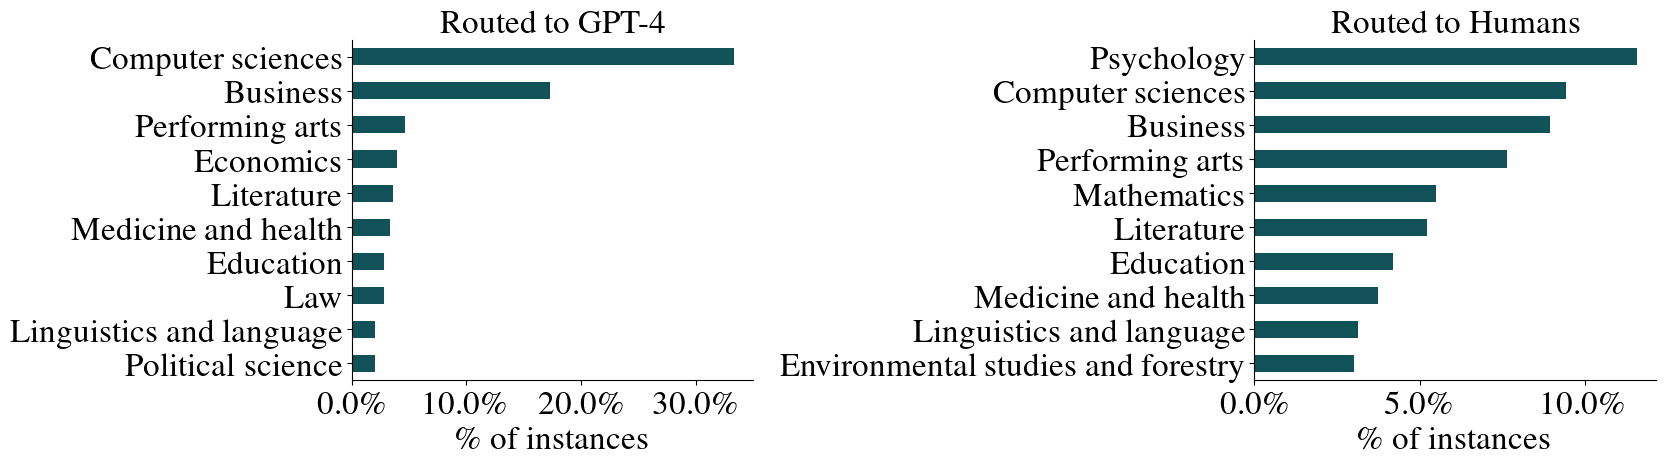

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(17, 5))
get_top_n_expertise(hs2_gpt4).iloc[::-1].rename(
    {"Journalism, media studies and communication": "Journalism"}
).normalize.plot.barh(ax=axs[0], color=COLORS.get("teal"))
axs[0].set_title("Routed to GPT-4")
get_top_n_expertise(hs2_hums).iloc[::-1].normalize.plot.barh(
    ax=axs[1], color=COLORS.get("teal")
)
axs[1].set_title("Routed to Humans")

for ax in axs:
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_xlabel("\% of instances")
    ax.xaxis.set_major_formatter(mtick.PercentFormatter())

plt.tight_layout()
fig.savefig("hs2_soe.pdf", bbox_inches="tight")

In [43]:
def get_multipref_soe_rankings(df):
    multipref_human_soe = [
        "Chemical engineering",
        "Religion",
        "Anthropology",
        "Chemistry",
        "Visual arts",
        "Earth sciences",
        "Space sciences",
    ]
    multipref_gpt4_soe = [
        "Logic",
        "Transportation",
        "Architecture and design",
        "Materials science and engineering",
        "Library and museum studies",
        "Media studies and communication",
        "Military sciences",
        "Family and consumer science",
    ]

    df_soe = (
        pd.DataFrame(
            [Counter([s for l in df.subject_of_expertise.to_list() for s in l])]
        )
        .T.sort_values(by=0, ascending=False)
        .reset_index()
        .rename(columns={0: "count", "index": "subject"})
    )

    return (
        df_soe[df_soe["subject"].isin(multipref_human_soe)].reset_index(drop=True),
        df_soe[df_soe["subject"].isin(multipref_gpt4_soe)].reset_index(drop=True),
    )

Create a grouped bar chart for this


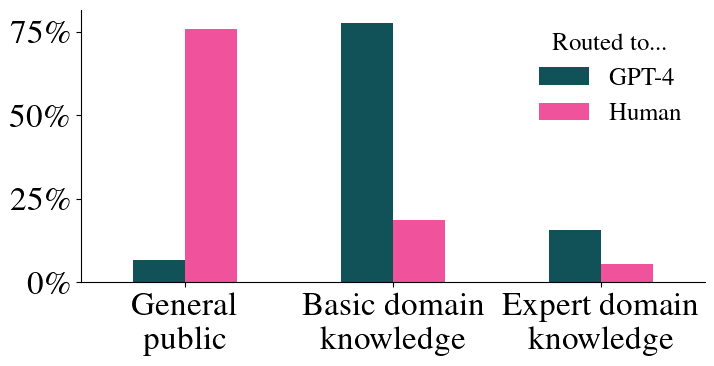

In [44]:
hs2_gpt4_elevel = hs2_gpt4.expertise_level.value_counts(normalize=True)[
    ["expert domain knowledge", "general public", "basic domain knowledge"]
].reset_index()
hs2_gpt4_elevel["routed_to"] = "gpt4"
hs2_hums_elevel = hs2_hums.expertise_level.value_counts(normalize=True).reset_index()
hs2_hums_elevel["routed_to"] = "human"
hs2_elevel = pd.concat([hs2_gpt4_elevel, hs2_hums_elevel]).reset_index(drop=True)
hs2_elevel["percentage"] = hs2_elevel["proportion"] * 100
hs2_elevel = hs2_elevel.replace({"gpt4": "GPT-4", "human": "Human"})

order = ["general public", "basic domain knowledge", "expert domain knowledge"]
pivot_df = hs2_elevel.pivot(
    index="expertise_level",
    columns="routed_to",
    values="percentage",
)
pivot_df = pivot_df.reindex(order)
pivot_df.index = [o.title() for o in order]

# Plotting the grouped bar chart
fig, ax = plt.subplots(1, 1, figsize=(7.5, 4))
pivot_df.plot(kind="bar", ax=ax, color=[COLORS.get("teal"), COLORS.get("pink")])

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Adding labels and title
ax.set_ylabel("")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(
    # loc="lower right",
    frameon=False,
    title="Routed to...",
)

ax.set_xticklabels(
    ["General\npublic", "Basic domain\nknowledge", "Expert domain\nknowledge"],
    rotation=0,
)

plt.tight_layout()
fig.savefig("hs2_loe.pdf", bbox_inches="tight")

In [45]:
hs2_gpt4.open_endedness.value_counts(normalize=True)

open_endedness
moderate    0.536461
high        0.321933
low         0.125495
no          0.016111
Name: proportion, dtype: float64

In [46]:
from sklearn.metrics import cohen_kappa_score

human_annotations = hs2_hums["pref_human"].to_list()
gpt4_annotations = hs2_hums["pref_gpt4"].to_list()


pct_agreement = len(hs2_hums[hs2_hums["pref_human"] == hs2_hums["pref_gpt4"]]) / len(
    hs2_hums
)
score = cohen_kappa_score(human_annotations, gpt4_annotations)

print(pct_agreement, score)

0.6152512998266898 0.30321496226930833


<Axes: >

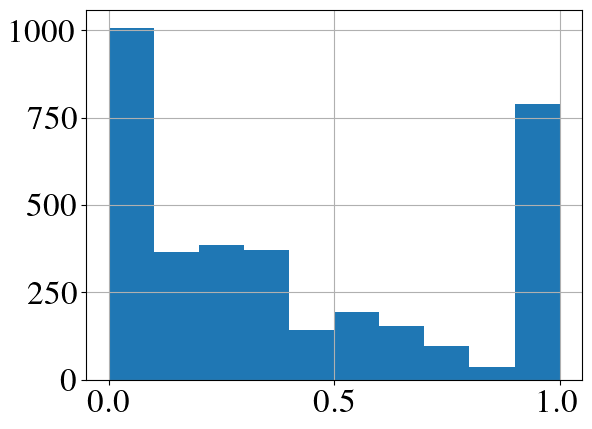

In [47]:
hs2_gpt4.entity_sim.hist()

<Axes: >

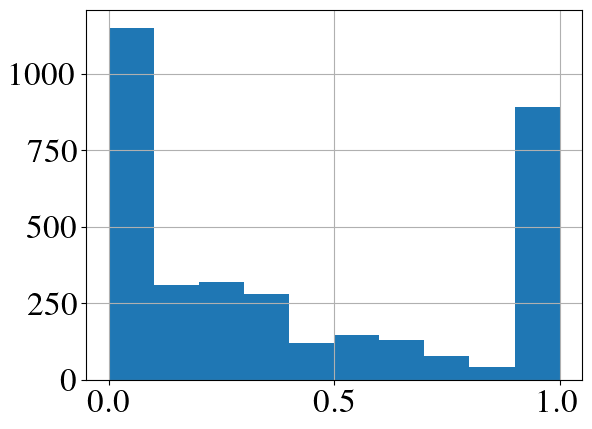

In [48]:
hs2_hums.entity_sim.hist()

In [49]:
hs2_gpt4.columns

Index(['id', 'source', 'highest_level_degree', 'prompt', 'chosen',
       'chosen_model', 'rejected', 'rejected_model', 'features_used',
       'is_swapped', 'text', 'response_a', 'response_b', 'pref_human',
       'pref_gpt4', 'rating_human', 'rating_gpt4', 'completions',
       'subject_of_expertise', 'expertise_level', 'languages',
       'open_endedness', 'safety_concern', 'complexity_of_intents',
       'type_of_in_context_material', 'format_constraints', 'cosine_sim',
       'token_len_diff', 'rouge', 'bertscore', 'len_longer', 'prompt_len',
       'bertscore_length', 'len_shorter', 'entity_sim', 'rating_chosen',
       'rating_rejected'],
      dtype='object')

In [50]:
hs2_hums.complexity_of_intents.value_counts()

complexity_of_intents
simple      2601
moderate     584
complex      277
Name: count, dtype: int64

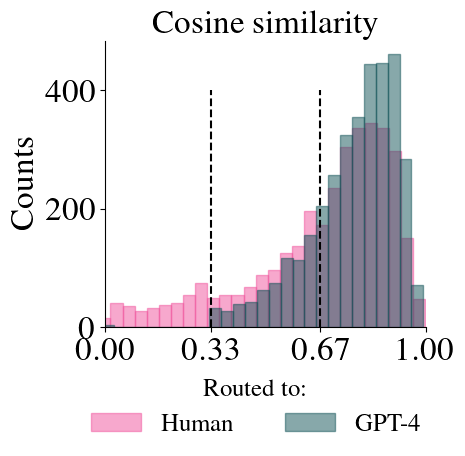

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
dim = "cosine_sim"
bins = 30
maxv = 400
hs2_hums[dim].hist(
    ax=ax,
    bins=bins,
    alpha=0.5,
    density=False,
    grid=False,
    label="Human",
    edgecolor=COLORS.get("pink"),
    color=COLORS.get("pink"),
)
hs2_gpt4[dim].hist(
    ax=ax,
    bins=bins,
    alpha=0.5,
    density=False,
    grid=False,
    label="GPT-4",
    edgecolor=COLORS.get("teal"),
    color=COLORS.get("teal"),
)
ax.vlines(0.33, 0, maxv, color="k", linestyles="--")
ax.vlines(0.67, 0, maxv, color="k", linestyles="--")
# ax.text(0.33 - 0.05, 0 - 50, "0.33")
# ax.text(0.67 - 0.05, 0 - 50, "0.67")
ax.set_xlim([0, 1])
ax.set_xticks([0, 0.33, 0.67, 1.0])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_title("ROUGE-L" if dim == "rouge" else "Cosine similarity")
ax.legend(title="Routed to:", frameon=False, ncols=2, bbox_to_anchor=(1.05, -0.10))
ax.set_ylabel("Counts")
plt.tight_layout()
# hs2_hums[dim].plot.kde(alpha=0.5)
# hs2_gpt4[dim].plot.kde(alpha=0.5)

In [52]:
hs2_hums["bertscore_length"].value_counts()

bertscore_length
0.000000e+00    41
1.000000e-10     7
3.000000e-10     2
3.200000e-09     2
2.000000e-10     2
                ..
5.480384e-01     1
1.040491e+00     1
6.558136e-01     1
6.197851e-01     1
2.030400e-06     1
Name: count, Length: 3413, dtype: int64

<Axes: >

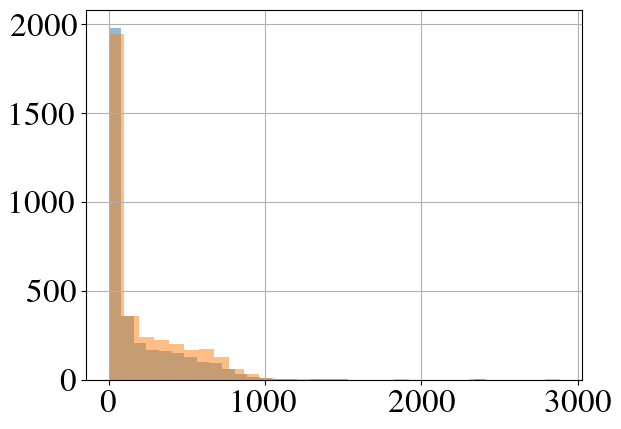

In [53]:
dim = "prompt_len"
hs2_hums[dim].hist(alpha=0.5, bins=30)
hs2_gpt4[dim].hist(alpha=0.5, bins=30)

In [54]:
dim = "expertise_level"
print("human")
print(hs2_hums[dim].value_counts(normalize=True).to_markdown())
print("gpt4")
print(hs2_gpt4[dim].value_counts(normalize=True).to_markdown())

human
| expertise_level         |   proportion |
|:------------------------|-------------:|
| general public          |    0.759388  |
| basic domain knowledge  |    0.185442  |
| expert domain knowledge |    0.0551704 |
gpt4
| expertise_level         |   proportion |
|:------------------------|-------------:|
| basic domain knowledge  |  0.776364    |
| expert domain knowledge |  0.155499    |
| general public          |  0.0675714   |
| high attitude           |  0.000282725 |
| highly specific         |  0.000282725 |


In [55]:
cs = hs2_gpt4[
    [
        "Computer sciences" in row["subject_of_expertise"]
        for _, row in hs2_gpt4.iterrows()
    ]
]

In [56]:
hs2_gpt4.expertise_level.value_counts()

expertise_level
basic domain knowledge     2746
expert domain knowledge     550
general public              239
high attitude                 1
highly specific               1
Name: count, dtype: int64

In [57]:
Counter(
    [
        j
        for i in hs2_gpt4[
            hs2_gpt4.expertise_level == "basic domain knowledge"
        ].subject_of_expertise.to_list()
        for j in i
    ]
)

Counter({'Computer sciences': 1504,
         'Business': 734,
         'Performing arts': 204,
         'Economics': 161,
         'Literature': 160,
         'Education': 120,
         'Medicine and health': 116,
         'Law': 110,
         'Linguistics and language': 83,
         'Political science': 79,
         'Journalism, media studies and communication': 78,
         'History': 66,
         'Electrical engineering': 61,
         'Physics': 56,
         'Biology': 55,
         'Visual arts': 52,
         'Philosophy': 50,
         'Mechanical engineering': 49,
         'Media studies and communication': 45,
         'Architecture and design': 43,
         'Chemistry': 40,
         'Journalism': 38,
         'Religion': 34,
         'Transportation': 34,
         'Sociology': 26,
         'Culinary arts': 23,
         'Civil engineering': 22,
         'Geography': 19,
         'Public administration': 19,
         'Others': 16,
         'Logic': 16,
         'Human physical perf

In [58]:
1504 / 2706

0.5558019216555802

In [59]:
cs[cs.expertise_level == "basic domain knowledge"]["prompt"].sample(10).to_list()

['Please act as a business intelligence and a business analyst while myself is a product owner. I have an application which focused on crowdsourced reporting where the reports will be delivered to the responsible government department. The application will also show the progress tracking of the reports filed. Please help me generate the questions required for the reporting form with the expected answer, answer type (numeric, longitude latitude, etc) and explanation\n<extra_id_1>Assistant\nIt sounds like your application will focus on providing a crowdsourced method of reporting incidents. A good set of questions for the reporting form would be:\n \n\n -What type of incident? (select from a list)\n -Incident date and time\n -Latitude and longitude of incident\n -Incident description, including any details about the incident that aren’t covered by the other questions\n -Any other relevant information\n<extra_id_1>User\nthe reporting is not only for incidents, but also for other activitie

In [60]:
cs[cs.expertise_level == "general public"]["prompt"].sample(10).to_list()

["how does my phone know when I'm sleeping?",
 'relocation jobs in dubai for web developers,full stack developers, nodejs developer,wordpress developer,php developer\n<extra_id_1>Assistant\nDid you want me to send you websites to find job opportunities in Dubai?\n<extra_id_1>User\nsend me websites to find job\n<extra_id_1>Assistant\nSure, here are some places to start looking for job opportunities in Dubai:\n \n\n https://www.jobs.ae/\n \n\n https://www.gulfjobs.com/\n \n\n https://www.dubajijob.com/\n \n\n https://www.dubai-jobs.net/\n \n\n https://www.careers.ae/\n<extra_id_1>User\nalso send me companies websites that hire pakistanis for uae and saudi arabia\n<extra_id_1>Assistant\nSure, here are some of the most popular websites for job listings in Saudi Arabia and the UAE that hire Pakistani workers:\n \n\n https://www.dccjob.com/\n \n\n https://www.naukri.com/\n \n\n https://www.qjobs.com.sa/\n \n\n https://www.fish4.co.uk/\n \n\n https://www.recruitment.ae/\n<extra_id_1>User\nsen

In [65]:
hs2_gpt4[hs2_gpt4["pref_human"] != hs2_gpt4["pref_gpt4"]].reset_index(drop=True).to_csv(
    "hs2_routed_to_gpt4_disagree.csv", index=False
)

In [66]:
humpref = hs2_gpt4["pref_human"]
gptpref = hs2_gpt4["pref_gpt4"]

In [69]:
sum(humpref == gptpref)

2038

In [71]:
2038 / len(humpref)

0.576031656302996

In [72]:
cohen_kappa_score(humpref.to_list(), gptpref.to_list())

0.22930673330614781